# Embedding Generator model training using combined dataset

<span style="color:blue">
Our initial embedding generator model is being trained using the MIT-BIH Arrhythmia dataset, a widely used ECG dataset. Each individual has a 30-minute ECG recording, which contributes to improved accuracy. In this notebook, we are experimenting with combining the MIT-BIH, PTB Diagnostic, and St. Petersburg datasets to train the embedding generator model.
</span>


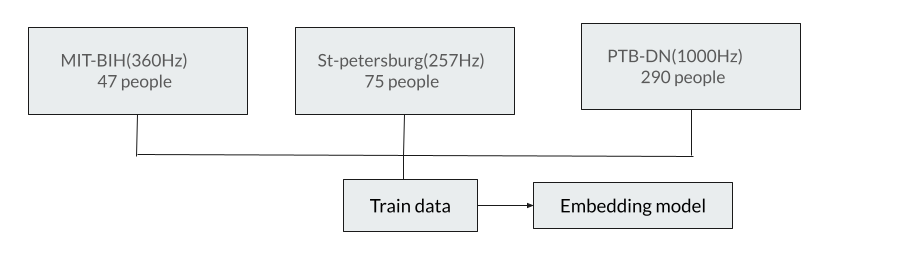

In [2]:
!pip install wfdb
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import butter, lfilter
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score,accuracy_score, confusion_matrix

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# Load the Lead II ECG signal from a specified record path.
def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

In [4]:
# Function to extract 10-second windows from a signal
def extract_10sec_windows(lead_ii, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = int(total_length // window_size)  # Number of full windows

    for i in range(max_windows):
        start = int(i * window_size)
        end = int(start + window_size)
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

In [5]:
# Scale the ECG signal to the range [0, 1]
def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

In [6]:
def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 2)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.contrrandom.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes,
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal


In [7]:
def flatten_patient_data(patient_data):
    X_train_original = []
    X_train_distorted = []
    X_test_original = []
    X_test_distorted = []
    y_train = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows_original = data['original_train']
        train_windows_distorted = data['distorted_train']
        test_windows_original = data['original_test']
        test_windows_distorted = data['distorted_test']

        X_train_original.extend(train_windows_original)
        X_train_distorted.extend(train_windows_distorted)
        X_test_original.extend(test_windows_original)
        X_test_distorted.extend(test_windows_distorted)
        
        num_train_samples = len(train_windows_original)
        num_test_samples = len(test_windows_original)

        y_train.extend([record_name] * num_train_samples)
        y_test.extend([record_name] * num_test_samples)

    X_train_original = np.array(X_train_original)
    X_train_distorted = np.array(X_train_distorted)
    X_test_original = np.array(X_test_original)
    X_test_distorted = np.array(X_test_distorted)
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    return X_train_original, X_train_distorted, X_test_original, X_test_distorted, y_train, y_test


# MIT-BIH-Arrhythmia dataset


In [8]:
def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)          
            lead_ii = load_lead_ii(record_path)
            
            total_duration = len(lead_ii) // 360
            if total_duration < 30:
                raise ValueError(f"Record {record_name} is shorter than 30 minutes.")

            # Split into 25-min train and 5-min test
            train_segment = lead_ii[:25*360*60]
            test_segment = lead_ii[25*360*60:]
            
            train_windows = extract_10sec_windows(train_segment)
            test_windows = extract_10sec_windows(test_segment)
            
            # Add distortions to both train and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Store the data
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'test': scaled_test_windows
            }
            
            original_train_windows = np.array(train_windows)
            original_test_windows = np.array(test_windows)

            # Add distortions to train, validation, and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Scale original windows as well
            scaled_original_train_windows = np.array([scale_signal(window) for window in original_train_windows])
            scaled_original_test_windows = np.array([scale_signal(window) for window in original_test_windows])

            # Store the original and distorted data
            patient_data[record_name] = {
                'original_train': scaled_original_train_windows,
                'distorted_train': scaled_train_windows,
                'original_test': scaled_original_test_windows,
                'distorted_test': scaled_test_windows
            }
    
    return patient_data

In [9]:
data_directory = '/kaggle/input/mit-bih-mitdb/mit-bih-arrhythmia-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)

In [10]:
mit_x_train, mit_x_train_distorted, mit_x_test,mit_x_test_distorted, mit_y_train, mit_y_test = flatten_patient_data(patient_data)


# Reshape X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
mit_x_train = mit_x_train.reshape((mit_x_train.shape[0], mit_x_train.shape[1], 1))
mit_x_train_distorted = mit_x_train_distorted.reshape((mit_x_train_distorted.shape[0], mit_x_train_distorted.shape[1], 1))
mit_x_test = mit_x_test.reshape((mit_x_test.shape[0], mit_x_test.shape[1], 1))
mit_x_test_distorted = mit_x_test_distorted.reshape((mit_x_test_distorted.shape[0], mit_x_test_distorted.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(mit_y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
mit_y_train = np.array([label_map[label] for label in mit_y_train])
mit_y_test = np.array([label_map[label] for label in mit_y_test])

num_classes = len(unique_labels)

print(f"X_train_original shape: {mit_x_train.shape}")
print(f"X_train_distorted shape: {mit_x_train_distorted.shape}")
print(f"X_test shape: {mit_x_test.shape}")
print(f"X_test_distorted shape: {mit_x_test_distorted.shape}")
print(f"y_train shape: {mit_y_train.shape}")
print(f"y_test shape: {mit_y_test.shape}")


X_train_original shape: (7200, 3600, 1)
X_train_distorted shape: (7200, 3600, 1)
X_test shape: (1440, 3600, 1)
X_test_distorted shape: (1440, 3600, 1)
y_train shape: (7200,)
y_test shape: (1440,)


In [11]:
np.unique(mit_y_train)
df = pd.DataFrame({'y_train': mit_y_train})

# Count the number of samples for each unique value in mit_y_train
counts = df['y_train'].value_counts()

print(counts)

y_train
3     150
12    150
25    150
36    150
37    150
24    150
2     150
44    150
45    150
34    150
42    150
7     150
19    150
14    150
41    150
20    150
0     150
26    150
10    150
21    150
35    150
33    150
38    150
16    150
15    150
47    150
6     150
32    150
5     150
8     150
39    150
31    150
40    150
11    150
9     150
23    150
18    150
29    150
27    150
28    150
13    150
22    150
30    150
43    150
46    150
4     150
17    150
1     150
Name: count, dtype: int64


# st-petersburg

In [12]:
import wfdb
import numpy as np
from scipy.signal import resample

def load_lead_ii(record_path, target_fs=360):
    # Load the record and extract lead II signal
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 1]
    
    # Get the original sampling frequency
    fs = wfdb.rdheader(record_path).fs
    
    # Resample the signal if the original fs is different from the target_fs
    if fs != target_fs:
        num_samples = int(len(lead_ii) * target_fs / fs)
        lead_ii = resample(lead_ii, num_samples)
    
    return lead_ii



In [13]:
def extract_10sec_windows(lead_ii, num_samples, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = total_length // window_size
    num_samples=max_windows
    
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

In [14]:
def split_train_test_windows(lead_ii, sampling_rate):
    total_length = len(lead_ii)
    train_length = 25 * 60 * sampling_rate  # 25 minutes
    test_length = 5 * 60 * sampling_rate  # 5 minutes

    if total_length < train_length + test_length:
        return np.array([]), np.array([])  # Return empty arrays instead of None

    train_windows = lead_ii[:train_length]
    test_windows = lead_ii[train_length:train_length + test_length]

    return train_windows, test_windows


def process_st_data(data_directory, num_samples=180, sampling_rate=360):
    patient_data = {}

    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            lead_ii = load_lead_ii(record_path)

            # Check if the signal is long enough
            if len(lead_ii) < (25 + 5) * 60 * sampling_rate:  # Total 30 minutes required
                print(len(lead_ii))
                print(f"Record {record_name} is too short and will be skipped.")
                continue

            # Extract train and test windows
            train_segment, test_segment = split_train_test_windows(lead_ii, sampling_rate)
            
            if train_segment.size == 0 or test_segment.size == 0:
                print(f"Record {record_name} does not have enough data for training/testing and will be skipped.")
                continue
            
            train_windows = extract_10sec_windows(train_segment, num_samples)
            test_windows = extract_10sec_windows(test_segment, num_samples // 5)
            
            # Add distortions to both train and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Store the data
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'test': scaled_test_windows
            }
            
            original_train_windows = np.array(train_windows)
            original_test_windows = np.array(test_windows)

            # Add distortions to train, validation, and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Scale original windows as well
            scaled_original_train_windows = np.array([scale_signal(window) for window in original_train_windows])
            scaled_original_test_windows = np.array([scale_signal(window) for window in original_test_windows])

            # Store the original and distorted data
            patient_data[record_name] = {
                'original_train': scaled_original_train_windows,
                'distorted_train': scaled_train_windows,
                'original_test': scaled_original_test_windows,
                'distorted_test': scaled_test_windows
            }
    
    return patient_data

In [15]:
data_directory='/kaggle/input/st-petersburg/files'
for record in os.listdir(data_directory)[:10]:
    
    if record.endswith('.dat'):
        load_a_lead_ii('files/'+os.path.splitext(record)[0])

In [16]:
patient_data = process_st_data(data_directory)

In [17]:
def extract_data(patient_data):
    st_x_train = []
    st_x_train_distorted = []
    st_x_test = []
    st_x_test_distorted = []
    st_y_train = []
    st_y_test = []

    for record_name, data in patient_data.items():
        original_train_windows = data['original_train']
        distorted_train_windows = data['distorted_train']
        original_test_windows = data['original_test']
        distorted_test_windows = data['distorted_test']

        st_x_train.append(original_train_windows)
        st_x_train_distorted.append(distorted_train_windows)
        st_x_test.append(original_test_windows)
        st_x_test_distorted.append(distorted_test_windows)

        label = record_name
        st_y_train.extend([label] * len(original_train_windows))
        st_y_test.extend([label] * len(original_test_windows))

    # Convert lists to numpy arrays
    st_x_train = np.concatenate(st_x_train) if st_x_train else np.array([])
    st_x_train_distorted = np.concatenate(st_x_train_distorted) if st_x_train_distorted else np.array([])
    st_x_test = np.concatenate(st_x_test) if st_x_test else np.array([])
    st_x_test_distorted = np.concatenate(st_x_test_distorted) if st_x_test_distorted else np.array([])
    st_y_train = np.array(st_y_train)
    st_y_test = np.array(st_y_test)

    return st_x_train, st_x_train_distorted, st_x_test, st_x_test_distorted, st_y_train, st_y_test

In [18]:
st_x_train, st_x_train_distorted, st_x_test,st_x_test_distorted, st_y_train, st_y_test = extract_data(patient_data)


# Reshape X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
st_x_train = st_x_train.reshape((st_x_train.shape[0], st_x_train.shape[1], 1))
st_x_train_distorted = st_x_train_distorted.reshape((st_x_train_distorted.shape[0], st_x_train_distorted.shape[1], 1))
st_x_test = st_x_test.reshape((st_x_test.shape[0], st_x_test.shape[1], 1))
st_x_test_distorted = st_x_test_distorted.reshape((st_x_test_distorted.shape[0], st_x_test_distorted.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(st_y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
st_y_train = np.array([label_map[label] for label in st_y_train])
st_y_test = np.array([label_map[label] for label in st_y_test])

num_classes = len(unique_labels)


In [19]:
# Reshape st X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
st_x_train = st_x_train.reshape((st_x_train.shape[0], st_x_train.shape[1], 1))
st_x_train_distorted = st_x_train_distorted.reshape((st_x_train_distorted.shape[0], 
                                                      st_x_train_distorted.shape[1], 1))
st_x_test = st_x_test.reshape((st_x_test.shape[0], st_x_test.shape[1], 1))
st_x_test_distorted = st_x_test_distorted.reshape((st_x_test_distorted.shape[0], 
                                                    st_x_test_distorted.shape[1], 1))


In [20]:
print(f"X_train_original shape: {st_x_train.shape}")
print(f"X_train_distorted shape: {st_x_train_distorted.shape}")
print(f"X_test shape: {st_x_test.shape}")
print(f"X_test_distorted shape: {st_x_test_distorted.shape}")
print(f"y_train shape: {st_y_train.shape}")
print(f"y_test shape: {st_y_test.shape}")

X_train_original shape: (11250, 3600, 1)
X_train_distorted shape: (11250, 3600, 1)
X_test shape: (2250, 3600, 1)
X_test_distorted shape: (2250, 3600, 1)
y_train shape: (11250,)
y_test shape: (2250,)


# PTB Diagnostic (PTB-DN)

In [31]:
data_directory='/kaggle/input/ptb-dn/ptb-diagnostic-ecg-database-1.0.0'
print("no of Patients", len(os.listdir(data_directory)))

no of Patients 295


In [35]:
def load_lead_ii(record_path, target_fs=360):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 1]
    
    fs = wfdb.rdheader(record_path).fs
    if fs != target_fs:
        num_samples = int(len(lead_ii) * target_fs / fs)
        lead_ii = resample(lead_ii, num_samples)
    
    return lead_ii

In [36]:
def flatten_patient_data(patient_data):
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        test_windows = data['test']

        # Flatten the training, validation, and testing windows
        X_train.extend(train_windows)
        X_test.extend(test_windows)

        num_train_samples = len(train_windows)
        num_test_samples = len(test_windows)
        
        y_train.extend([record_name] * num_train_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

In [38]:
def extract_10sec_windows(signal):
    windows = []
    for i in range(0, len(signal) - 3600, 3600):  # 3600 samples correspond to 10 seconds
        window = signal[i:i + 3600]
        if len(window) == 3600:
            windows.append(window)
    return windows

In [40]:
def process_ptb_dn_data(data_directory, target_fs=360, wavelet='db6', level=4, pre_r=60, post_r=100):
    patient_data = {}
    for patient in os.listdir(data_directory):
        patient_path = os.path.join(data_directory, patient)
        
        if os.path.isdir(patient_path):
            for record in os.listdir(patient_path):
                if record.endswith('.dat'):
                    record_name = os.path.splitext(record)[0]
                    record_path = os.path.join(patient_path, record_name)
                    
                    # Load and resample the signal to 360 Hz
                    lead_ii = load_lead_ii(record_path, target_fs=target_fs)
                        
                    # Calculate split points based on percentages
                    train_split = int(0.830 * len(lead_ii))
                    test_split = int(0.17 * len(lead_ii))  # 83% + 17%

                    # Split into train, validation, and test segments
                    train_segment = lead_ii[:train_split]
                    test_segment = lead_ii[test_split:]

                    # Extract 10-second windows for train, validation, and test sets
                    train_windows = extract_10sec_windows(train_segment)
                    test_windows = extract_10sec_windows(test_segment)
                    
                    # Add distortions and scale the signals
                    distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
                    distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
                    
                    scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
                    scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
                    
                    # Store original and distorted windows
                    patient_data[record_name] = {
                        'original_train': np.array([scale_signal(window) for window in train_windows]),
                        'distorted_train': scaled_train_windows,
                        'original_test': np.array([scale_signal(window) for window in test_windows]),
                        'distorted_test': scaled_test_windows
                    }
    
    return patient_data


data_directory = '/kaggle/input/ptb-dn/ptb-diagnostic-ecg-database-1.0.0'
patient_data = process_ptb_dn_data(data_directory, target_fs=360)

# Flatten the patient data for training and testing sets
ptbdn_x_train, ptbdn_x_train_distorted, ptbdn_x_test, ptbdn_x_test_distorted, ptbdn_y_train, ptbdn_y_test = extract_data(patient_data)

# Reshape ptbdn X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
ptbdn_x_train = ptbdn_x_train.reshape((ptbdn_x_train.shape[0], ptbdn_x_train.shape[1], 1))
ptbdn_x_train_distorted = ptbdn_x_train_distorted.reshape((ptbdn_x_train_distorted.shape[0], ptbdn_x_train_distorted.shape[1], 1))
ptbdn_x_test = ptbdn_x_test.reshape((ptbdn_x_test.shape[0], ptbdn_x_test.shape[1], 1))
ptbdn_x_test_distorted = ptbdn_x_test_distorted.reshape((ptbdn_x_test_distorted.shape[0], ptbdn_x_test_distorted.shape[1], 1))

# Print the shapes of the extracted datasets
print(f"X_train_original shape: {ptbdn_x_train.shape}")
print(f"X_train_distorted shape: {ptbdn_x_train_distorted.shape}")
print(f"X_test_original shape: {ptbdn_x_test.shape}")
print(f"X_test_distorted shape: {ptbdn_x_test_distorted.shape}")
print(f"y_train shape: {ptbdn_y_train.shape}")
print(f"y_test shape: {ptbdn_y_test.shape}")

X_train_original shape: (4611, 3600, 1)
X_train_distorted shape: (4611, 3600, 1)
X_test_original shape: (4611, 3600, 1)
X_test_distorted shape: (4611, 3600, 1)
y_train shape: (4611,)
y_test shape: (4611,)


In [28]:
np.unique(ptbdn_y_train)
df = pd.DataFrame({'y_train': ptbdn_y_train})

# Count the number of samples for each unique value in mit_y_train
counts = df['y_train'].value_counts()

print(counts)

y_train
s0555_re    49
s0430_re    49
s0479_re    49
s0502_re    49
s0556_re    49
            ..
s0291lre    47
s0238lre    47
s0243lre    47
s0252lre    47
s0249lre    47
Name: count, Length: 491, dtype: int64


In [41]:
X_train = np.concatenate([st_x_train, ptbdn_x_train, mit_x_train])
X_train_distorted = np.concatenate([st_x_train_distorted, ptbdn_x_train_distorted, mit_x_train_distorted])
y_train = np.concatenate([st_y_train, ptbdn_y_train, mit_y_train])

X_test = np.concatenate([st_x_test, ptbdn_x_test, mit_x_test])
X_test_distorted = np.concatenate([st_x_test_distorted, ptbdn_x_test_distorted, mit_x_test_distorted])
y_test = np.concatenate([st_y_test, ptbdn_y_test, mit_y_test])

print("Training data shape:", X_train.shape, y_train.shape)
print("Training distorted data shape:", X_train_distorted.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)
print("Test data shape:", X_test_distorted.shape, y_test.shape)

Training data shape: (23061, 3600, 1) (23061,)
Training distorted data shape: (23061, 3600, 1) (23061,)
Test data shape: (8301, 3600, 1) (8301,)
Test data shape: (8301, 3600, 1) (8301,)


In [42]:
unique_labels = np.unique(y_train)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

# Convert string labels to integers
y_train = np.array([label_to_int[label] for label in y_train])
y_test= np.array([label_to_int[label] for label in y_test])

In [43]:
y_train.shape, y_test.shape

((23061,), (8301,))

# Embedding Generator Model

In [44]:
def create_CNN_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(512, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(512, activation=None, 
                     kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
        layers.Dropout(0.2),  # Dropout layer
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  
    ])
    return model

input_shape = (X_train.shape[1], 1)
cnn_model = create_CNN_model(input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
def contrastive_loss(y_true, y_pred, margin=2.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [46]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [47]:
def create_siamese_network(input_shape):
    input_A = layers.Input(shape=input_shape)
    input_B = layers.Input(shape=input_shape)
    
    # Pass both inputs through the FaceNet model
    embeddings_A = cnn_model(input_A)
    embeddings_B = cnn_model(input_B)
    
    # Compute the Euclidean distance between the embeddings
    distance = layers.Lambda(euclidean_distance)([embeddings_A, embeddings_B])
    
    # The Siamese network will output the distance between the embeddings
    siamese_network = models.Model(inputs=[input_A, input_B], outputs=distance)
    return siamese_network

siamese_network = create_siamese_network(input_shape)
siamese_network.compile(loss=contrastive_loss, optimizer='adam')

In [48]:
def create_pairs(X_original, X_distorted, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(X_original)):
        # Anchor: original signal
        anchor = X_original[idx1]
        
        # Positive pair: distorted version of the same signal
        positive = X_distorted[idx1]
        pairs.append([anchor, positive])
        labels.append(1)  # Positive label
        
        # Negative pair: distorted signal from a different patient
        while True:
            neg_idx = random.randint(0, len(X_distorted) - 1) 
            if y[neg_idx] != y[idx1]:  
                negative = X_distorted[neg_idx]
                pairs.append([anchor, negative])
                labels.append(0)  
                break  

    return np.array(pairs), np.array(labels)


pairs_train, labels_train = create_pairs(X_train, X_train_distorted, y_train)
pairs_test, labels_test = create_pairs(X_test, X_test_distorted, y_test)

# Convert labels to integer type
labels_train = labels_train.astype(int)
labels_test = labels_test.astype(int)


# Training

In [49]:
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20


I0000 00:00:1729257018.184451     328 service.cc:145] XLA service 0x7deee8003530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729257018.184509     328 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729257018.184513     328 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1442 ━━━━━━━━━━━━━━━━━━━━ 3:31:52 9s/step - loss: 6.2210

I0000 00:00:1729257024.845471     328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1442/1442 ━━━━━━━━━━━━━━━━━━━━ 117s 75ms/step - loss: 1.0890 - val_loss: 0.6050
Epoch 2/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5840 - val_loss: 0.5034
Epoch 3/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5205 - val_loss: 0.4316
Epoch 4/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5184 - val_loss: 0.4342
Epoch 5/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5182 - val_loss: 0.4563
Epoch 6/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5148 - val_loss: 0.4781
Epoch 7/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5191 - val_loss: 0.4198
Epoch 8/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 72ms/step - loss: 0.5109 - val_loss: 0.4109
Epoch 9/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5082 - val_loss: 0.4149
Epoch 10/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 104s 72ms/step - loss: 0.5113 - val_loss: 0.4205
Epoch 11/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - loss: 0.5079 - val_loss: 0.4185
Epoch 12

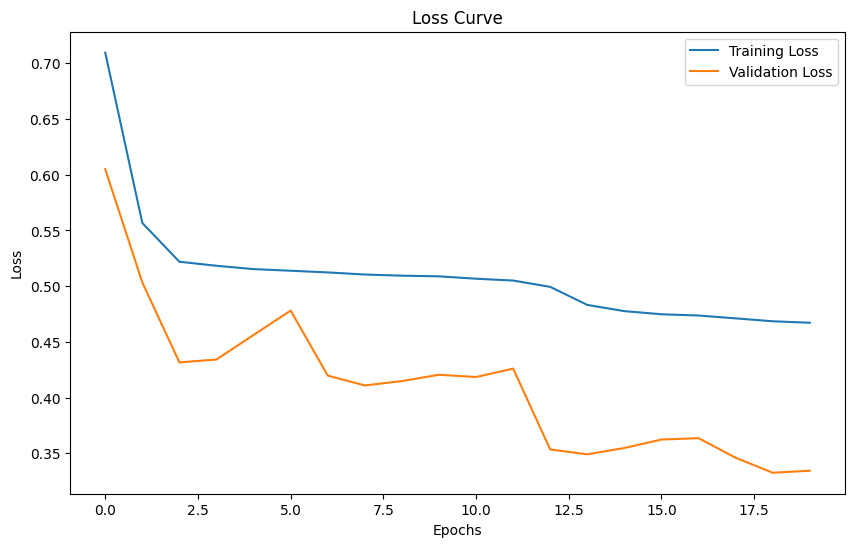

In [50]:
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history)

# Identification

## 1. KNN

In [51]:
def custom_knn(embeddings_train, labels_train, embeddings_test, k=2):
    predictions = []
    
    for test_embedding in embeddings_test:
        distances = np.linalg.norm(embeddings_train - test_embedding, axis=1)
        knn_indices = np.argsort(distances)[:k]
        knn_labels = labels_train[knn_indices]
        unique_labels, counts = np.unique(knn_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        
        predictions.append(predicted_label)
    
    return np.array(predictions)

In [52]:
def generate_embeddings(model, X):
    embeddings = model.predict(X)
    return embeddings

In [54]:
embeddings_train = generate_embeddings(cnn_model, mit_x_train)
embeddings_test = generate_embeddings(cnn_model, mit_x_test)
predicted_labels = custom_knn(embeddings_train, mit_y_train, embeddings_test, k=2)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(mit_y_test, predicted_labels)
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)

print("-----------MIT- BIH dataset---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
-----------MIT- BIH dataset---------------
Precision: 63.78%
Recall: 62.99%
Accuracy: 62.99%
Confusion Matrix:
 [[19  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0 24]]


In [ ]:
embeddings_train = generate_embeddings(cnn_model, ptbdn_x_train)
embeddings_test = generate_embeddings(cnn_model, ptbdn_x_test)
predicted_labels = custom_knn(embeddings_train, ptbdn_y_train, embeddings_test, k=10)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(ptbdn_y_test, predicted_labels, average='macro')
recall = recall_score(ptbdn_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(ptbdn_y_test, predicted_labels)
conf_matrix = confusion_matrix(ptbdn_y_test, predicted_labels)

print("-----------PTB-DN dataset---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
embeddings_train = generate_embeddings(cnn_model, st_x_train)
embeddings_test = generate_embeddings(cnn_model, st_x_test)
predicted_labels = custom_knn(embeddings_train, st_y_train, embeddings_test, k=10)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(st_y_test, predicted_labels, average='macro')
recall = recall_score(st_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(st_y_test, predicted_labels)
conf_matrix = confusion_matrix(st_y_test, predicted_labels)

print("-----------ST-Petersburg dataset---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

# XGBOOST

In [ ]:
from xgboost import XGBClassifier

def custom_xgboost(embeddings_train, labels_train, embeddings_test):
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(embeddings_train, labels_train)
    predicted_labels = xgb_model.predict(embeddings_test)

    return predicted_labels


In [ ]:
embeddings_train = generate_embeddings(cnn_model, mit_x_train)
embeddings_test = generate_embeddings(cnn_model, mit_x_test)

predicted_labels = custom_xgboost(embeddings_train, mit_y_train, embeddings_test)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(mit_y_test, predicted_labels)
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)

print("-----------MIT-BIH dataset- xgboost---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
embeddings_train = generate_embeddings(cnn_model, ptbxl_X_train)
embeddings_test = generate_embeddings(cnn_model, ptbxl_X_test)
predicted_labels = custom_xgboost(embeddings_train, ptbxl_y_train, embeddings_test)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(ptbxl_y_test, predicted_labels, average='macro')
recall = recall_score(ptbxl_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(ptbxl_y_test, predicted_labels)
conf_matrix = confusion_matrix(ptbxl_y_test, predicted_labels)

print("-----------PTB-XL dataset--xgboost---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def custom_xgboost(embeddings_train, labels_train, embeddings_test):
    # Encode labels
    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    
    # Train XGBoost model
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(embeddings_train, labels_train_encoded)
    
    # Predict using the trained model
    predicted_labels_encoded = xgb_model.predict(embeddings_test)
    
    # Decode predicted labels back to original strings
    predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

    return predicted_labels

# Generate embeddings
embeddings_train = generate_embeddings(cnn_model, ptbxl_X_train)
embeddings_test = generate_embeddings(cnn_model, ptbxl_X_test)

# Run the custom XGBoost function
predicted_labels = custom_xgboost(embeddings_train, ptbxl_y_train, embeddings_test)

# Calculate precision, recall, and confusion matrix
precision = precision_score(ptbxl_y_test, predicted_labels, average='macro')
recall = recall_score(ptbxl_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(ptbxl_y_test, predicted_labels)
conf_matrix = confusion_matrix(ptbxl_y_test, predicted_labels)

# Print results
print("-----------PTB-XL dataset--xgboost---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
embeddings_train = generate_embeddings(cnn_model, ptbdn_x_train)
embeddings_test = generate_embeddings(cnn_model, ptbdn_x_test)
predicted_labels = custom_xgboost(embeddings_train, ptbdn_y_train, embeddings_test)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(ptbdn_y_test, predicted_labels, average='macro')
recall = recall_score(ptbdn_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(ptbdn_y_test, predicted_labels)
conf_matrix = confusion_matrix(ptbdn_y_test, predicted_labels)

print("-----------PTB-DN dataset- xgboost---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
embeddings_train = generate_embeddings(cnn_model, st_x_train)
embeddings_test = generate_embeddings(cnn_model, st_x_test)
predicted_labels = custom_xgboost(embeddings_train, st_y_train, embeddings_test)

 # Calculate precision, recall, and confusion matrix
precision = precision_score(st_y_test, predicted_labels, average='macro')
recall = recall_score(st_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(st_y_test, predicted_labels)
conf_matrix = confusion_matrix(st_y_test, predicted_labels)

print("-----------ST-Petersburg dataset - Xgboost---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Save the model
cnn_model.save('/kaggle/working/cnn_model.h5')


# Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_nn_classifier(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))  
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    return model

In [ ]:
embeddings_train = generate_embeddings(cnn_model, mit_x_train)
embeddings_test = generate_embeddings(cnn_model, mit_x_test)

input_dim = embeddings_train.shape[1]
num_classes = len(np.unique(mit_y_train))  

classifier_model = build_nn_classifier(input_dim, num_classes)

classifier_model.compile(optimizer='adam', 
                         loss='sparse_categorical_crossentropy', 
                         metrics=['accuracy'])

classifier_model.fit(embeddings_train, mit_y_train, 
                     validation_split=0.2, 
                     epochs=500, 
                     batch_size=32)

In [ ]:
predicted_labels = np.argmax(classifier_model.predict(embeddings_test), axis=1)

precision = precision_score(mit_y_test, predicted_labels, average='macro')
recall = recall_score(mit_y_test, predicted_labels, average='macro')
accuracy = accuracy_score(mit_y_test, predicted_labels)
conf_matrix = confusion_matrix(mit_y_test, predicted_labels)

print("-----------MIT- BIH dataset -neural---------------")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)
